In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.parallel
import random
import matplotlib.pyplot as plt
import parameters as var #Configuration and coarsening parameters
var.init() #initializes parameters
import utils as ut #Some utility functions 
import loss_function as lf #Custom loss function

import operators_torch as op #Interpolator and prolongator given a set of test vectors
from opendataset import ConfsDataset #class for opening gauge confs
import model as mod #import machine learning model
from train import train, evaluate
from torchsummary import summary

#import convert_to_pt
#convert_to_pt.binaryPlaq2ptPlaq() #to convert binaries to .pt files

var.print_parameters()
device = var.DEVICE

*********** Configuration parameters ***********
* β=2, Nx=32, Nt=32
* Variables=2048
* m0=-0.1884
* blocks_x=2, blocks_t=2 (for the aggregation)
* SAP vectors for the loss function Nv=30
* Fake test vectors generated Nv=15
* Number of confs=1000
* Confs used for training=900
* Device: cuda:0
* Precision: single
************************************************


In [2]:
"""
Loading the configurations and the near-kernel test vectors
We split train and test set
"""
dataset = ConfsDataset()                     
total_len = len(dataset)                    
train_len = int(var.TRAIN_PROP * total_len) 
test_len  = total_len - train_len   
torch.manual_seed(42)                       # <-- any integer you like

train_set, test_set = torch.utils.data.random_split(
    dataset,
    [train_len,  test_len]          # lengths in the same order
)

workers    = 2
# Batch size
batch_size = 100

#train dataloader
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,          # we usually want shuffling *only* for training
    num_workers=workers,
    pin_memory=True
)

#test dataloader
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True
)

#----returns a tensor of size [ [batch_size,4,Nt,Nx], [batch_size,Nv,2,Nt,Nx], [batch_size]]----#
#    The first entry is real and second one complex. The last entry has the indices of the confs.
first_batch = next(iter(train_loader)) 
#--------------------------------------

#first_batch[0][0].shape
#print("Re(U0)",first_batch[0][0][0,0,0])
#print("Re(U1)",first_batch[0][0][1,0,0])
#print("Im(U0)",first_batch[0][0][2,0,0])
#print("Im(U1)",first_batch[0][0][3,0,0])

In [3]:
"""
Custom weights initialization
"""  
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 1.0) #nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 1.0)
        nn.init.constant_(m.bias.data, 0.0) #nn.init.constant_(m.bias.data, 0.0)

In [4]:
"""
Declare the model
"""
model = mod.TvGenerator(var.NGPU,batch_size).to(device)
if (device.type == 'cuda') and (var.NGPU > 1):
    model = nn.DataParallel(model, list(range(var.NGPU)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
model.apply(weights_init)
#print("")
# Print the model
#print(model)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
data_points = 6*var.NX*var.NT*train_len
predicted_data = 4*var.NX*var.NV_PRED*var.NT
ratio = np.round(params/data_points,4)
print("Total number of (trainable) model parameters",params)
print("Total number of real data points (6·Nx·Nt·train_len)",data_points)
print("Total number of expected predicted real numbers",predicted_data)
print("Parameters/data points = {0}".format(ratio))
if ratio > 1.0:
    print("Model needs more data to prevent overfit")
#summary(model, input_size=(6, var.NT, var.NX))

Total number of (trainable) model parameters 31720704
Total number of real data points (6·Nx·Nt·train_len) 5529600
Total number of expected predicted real numbers 61440
Parameters/data points = 5.7365
Model needs more data to prevent overfit


In [5]:
# Learning rate for optimizers
lr = 0.01
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.9
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999),weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)

In [6]:
version = 1
import time

start = time.time()

epochs = 20
losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, optimizer,losses,version)
print("Done!")

end = time.time()
print(end - start,"s")
#20 epochs double precision 921s , NV = 30, NV_PRED= 15
#20 epochs single precision 759 s, NV = 30, NV_PRED= 15

Epoch 1
-------------------------------
loss: 0.970014  [  100/  900]
loss: 0.961727  [  200/  900]
loss: 0.950377  [  300/  900]
loss: 0.947400  [  400/  900]
loss: 0.943384  [  500/  900]
loss: 0.939836  [  600/  900]
loss: 0.932268  [  700/  900]
loss: 0.937235  [  800/  900]
loss: 0.930996  [  900/  900]
Epoch 2
-------------------------------
loss: 0.888547  [  100/  900]
loss: 0.879516  [  200/  900]
loss: 0.867380  [  300/  900]
loss: 0.880785  [  400/  900]
loss: 0.877799  [  500/  900]
loss: 0.876069  [  600/  900]
loss: 0.876348  [  700/  900]
loss: 0.873346  [  800/  900]
loss: 0.874001  [  900/  900]
Epoch 3
-------------------------------
loss: 0.837798  [  100/  900]
loss: 0.845557  [  200/  900]
loss: 0.836714  [  300/  900]
loss: 0.843033  [  400/  900]
loss: 0.840189  [  500/  900]
loss: 0.831393  [  600/  900]
loss: 0.842097  [  700/  900]
loss: 0.827463  [  800/  900]
loss: 0.832883  [  900/  900]
Epoch 4
-------------------------------
loss: 0.802992  [  100/  900]


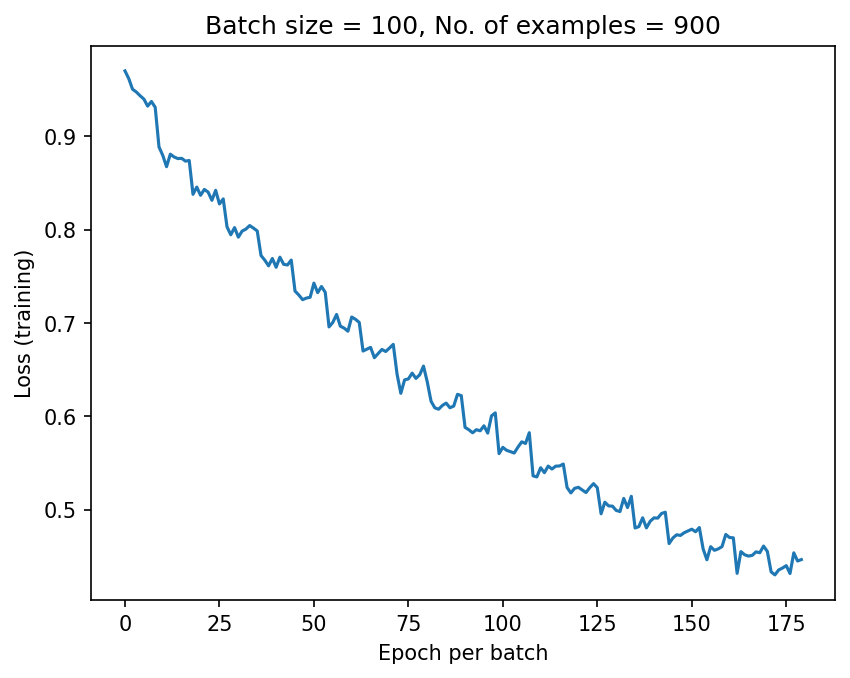

In [7]:
fig = plt.figure(dpi=150)
plt.plot(np.arange(len(losses)),losses)
plt.title("Batch size = {0}, No. of examples = {1}".format(batch_size,train_len))
plt.ylabel("Loss (training)")
plt.xlabel("Epoch per batch")
plt.show()
#fig.savefig("Loss6.png")

# Check loss on test set

In [8]:
test_loss, dtest_loss, test_batch_losses = evaluate(test_loader, model, device,version)
print(f'Test average loss: {test_loss:.6f} +- {dtest_loss:.6f}')

Test average loss: 0.938172 +- 0.000000


In [9]:
#fig = plt.figure(dpi=150)
#plt.plot(np.arange(len(test_batch_losses)),test_batch_losses,linestyle='',marker='o',markersize=10)
#plt.title("Batch size = {0}, No. of examples = {1}".format(batch_size,test_len))
#plt.ylabel("Loss (test)")
#plt.xlabel("ID")
#plt.show()

In [10]:
#ut.SavePredictions(test_loader, model, device)
#ut.SavePredictions(train_loader, model, device)

In [11]:
with torch.no_grad():
    batch = next(iter(test_loader)) 
    confs_batch = batch[0].to(device)          # (B, …)
    pred = model(confs_batch)                  # (B, 4*NV, NT, NX)
    confsID = batch[2]
    B = pred.shape[0]
    pred = pred.view(B, var.NV_PRED, 4, var.NT, var.NX)   # (B,NV,4,NT,NX)
    # Build complex tensor (B,NV,2,NT,NX)
    real = torch.stack([pred[:, :, 0], pred[:, :, 1]], dim=2)   # (B,NV,2,NT,NX)
    imag = torch.stack([pred[:, :, 2], pred[:, :, 3]], dim=2)   # (B,NV,2,NT,NX)
    pred_complex = torch.complex(real, imag)
    norms = torch.linalg.vector_norm(pred_complex[:,:],dim=(-3,-2, -1)).view(batch_size, var.NV_PRED, 1, 1, 1)
    pred_complex_normalized = pred_complex / norms
    pred_complex_normalized = pred_complex_normalized.cpu().detach().numpy()

Norm 12.862091 1.0


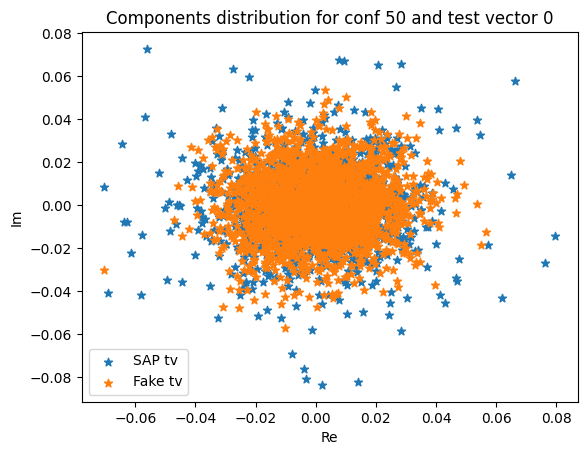

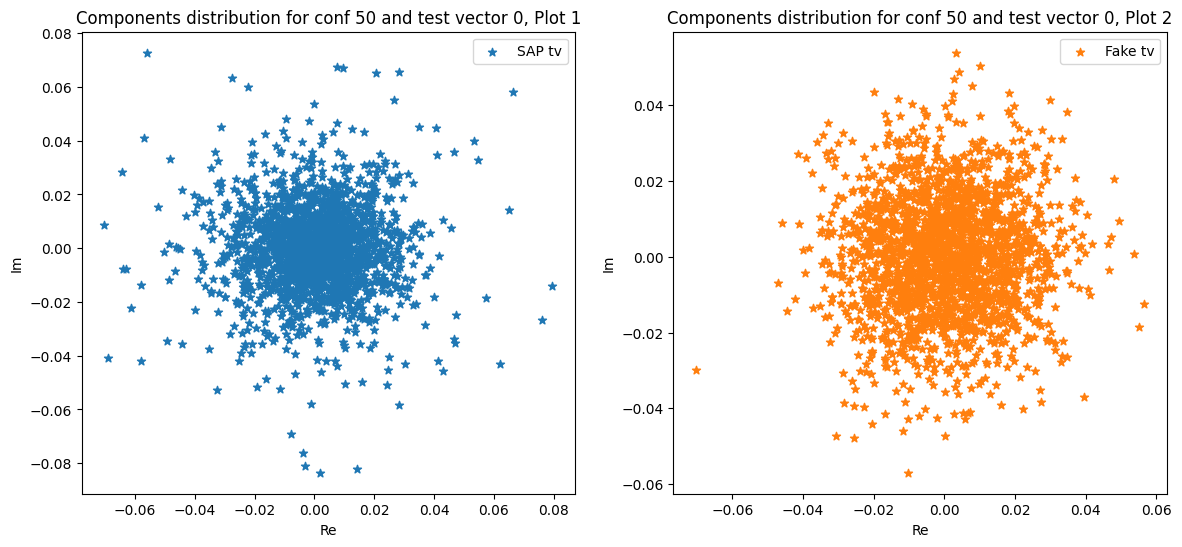

In [12]:
tv = 0
conf = 50 #ConfID in the test_loader
norm = np.linalg.norm(batch[1][conf][tv].reshape(2*var.NX*var.NT))
norm_pred = np.linalg.norm(pred_complex_normalized[conf,tv].reshape(2*var.NX*var.NT))
print("Norm",norm,norm_pred)

plt.title("Components distribution for conf {0} and test vector {1}".format(conf,tv))

plt.scatter(np.real(batch[1][conf][tv].reshape(2*var.NX*var.NT))/norm,
            np.imag(batch[1][conf][tv].reshape(2*var.NX*var.NT))/norm,
            marker="*",label="SAP tv")

plt.scatter(np.real(pred_complex_normalized[conf,tv].reshape(2*var.NX*var.NT))/norm_pred,
            np.imag(pred_complex_normalized[conf,tv].reshape(2*var.NX*var.NT))/norm_pred,
            marker="*",
            label="Fake tv")

plt.xlabel("Re")
plt.ylabel("Im")
plt.legend()
plt.show()
#fig.savefig("scatter_test_set.png")

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Plot 1
axs[0].scatter(np.real(batch[1][conf][tv].reshape(2*var.NX*var.NT))/norm,
               np.imag(batch[1][conf][tv].reshape(2*var.NX*var.NT))/norm,
               marker="*",
               label="SAP tv")
axs[0].set_title(f"Components distribution for conf {conf} and test vector {tv}, Plot 1")
axs[0].set_xlabel("Re")
axs[0].set_ylabel("Im")
axs[0].legend()

axs[1].scatter(np.real(pred_complex_normalized[conf,tv].reshape(2*var.NX*var.NT))/norm_pred,
               np.imag(pred_complex_normalized[conf,tv].reshape(2*var.NX*var.NT))/norm_pred,
               marker="*",
               color="tab:orange",
               label="Fake tv")
axs[1].set_title(f"Components distribution for conf {conf} and test vector {tv}, Plot 2")
axs[1].set_xlabel("Re")
axs[1].set_ylabel("Im")
axs[1].legend()

plt.show()

In [13]:
with torch.no_grad():
    batch = next(iter(train_loader)) 
    confs_batch = batch[0].to(device)          # (B, …)
    pred = model(confs_batch)                  # (B, 4*NV, NT, NX)
    confsID = batch[2]
    B = pred.shape[0]
    pred = pred.view(B, var.NV_PRED, 4, var.NT, var.NX)   # (B,NV,4,NT,NX)
    # Build complex tensor (B,NV,2,NT,NX)
    real = torch.stack([pred[:, :, 0], pred[:, :, 1]], dim=2)   # (B,NV,2,NT,NX)
    imag = torch.stack([pred[:, :, 2], pred[:, :, 3]], dim=2)   # (B,NV,2,NT,NX)
    pred_complex = torch.complex(real, imag)
    norms = torch.linalg.vector_norm(pred_complex[:,:],dim=(-3,-2, -1)).view(batch_size, var.NV_PRED, 1, 1, 1)
    pred_complex_normalized = pred_complex / norms
    pred_complex_normalized = pred_complex_normalized.cpu().detach().numpy()

Norm 11.212381 1.0


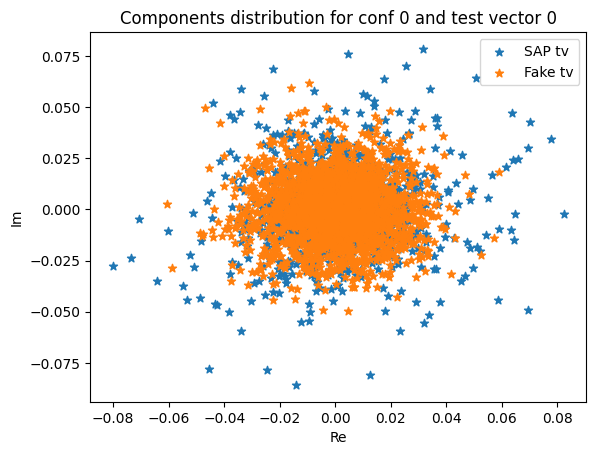

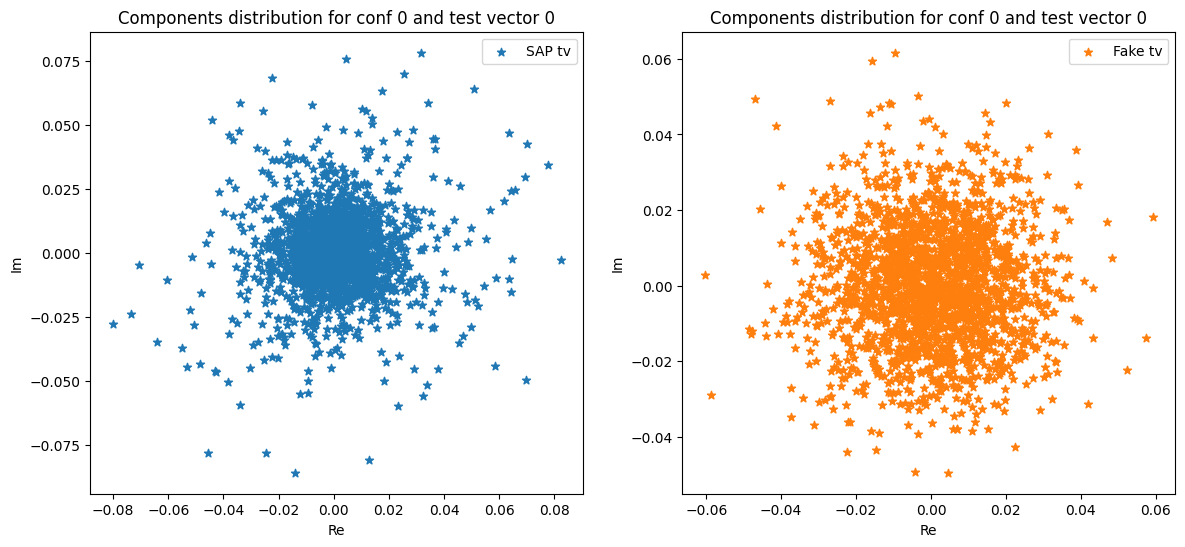

In [14]:
tv = 0
conf = 0 #ConfID in the train loader

norm = np.linalg.norm(batch[1][conf][tv].reshape(2*var.NX*var.NT))
norm_pred = np.linalg.norm(pred_complex_normalized[conf,tv].reshape(2*var.NX*var.NT))
print("Norm",norm,norm_pred)

plt.title("Components distribution for conf {0} and test vector {1}".format(conf,tv))

plt.scatter(np.real(batch[1][conf][tv].reshape(2*var.NX*var.NT))/norm,
            np.imag(batch[1][conf][tv].reshape(2*var.NX*var.NT))/norm,
            marker="*",
            label="SAP tv")

plt.scatter(np.real(pred_complex_normalized[conf,tv].reshape(2*var.NX*var.NT))/norm_pred,
            np.imag(pred_complex_normalized[conf,tv].reshape(2*var.NX*var.NT))/norm_pred,
            marker="*",
            label="Fake tv")
plt.xlabel("Re")
plt.ylabel("Im")
plt.legend()
plt.show()
#fig.savefig("scatter_train_set.png")

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Plot 1
axs[0].scatter(np.real(batch[1][conf][tv].reshape(2*var.NX*var.NT))/norm,
               np.imag(batch[1][conf][tv].reshape(2*var.NX*var.NT))/norm,
               marker="*",
               label="SAP tv")
axs[0].set_title(f"Components distribution for conf {conf} and test vector {tv}")
axs[0].set_xlabel("Re")
axs[0].set_ylabel("Im")
axs[0].legend()

axs[1].scatter(np.real(pred_complex_normalized[conf,tv].reshape(2*var.NX*var.NT))/norm_pred,
               np.imag(pred_complex_normalized[conf,tv].reshape(2*var.NX*var.NT))/norm_pred,
               marker="*",
               color="tab:orange",
               label="Fake tv")
axs[1].set_title(f"Components distribution for conf {conf} and test vector {tv}")
axs[1].set_xlabel("Re")
axs[1].set_ylabel("Im")
axs[1].legend()

plt.show()